In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sfp_nsdsyn.two_dimensional_model as two_d
import sfp_nsdsyn.cross_validation_2d_model as cv2d
import sfp_nsdsyn.utils as utils
import warnings
import json
import matplotlib as mpl
from itertools import product

# Load the JSON file
with open("../config.json", "r") as file:
    config = json.load(file)
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
dset='nsdsyn'
subj='subj01'
roi='V1'
vs='pRFsize'
max_epoch=30000
lr=0.0005
model_type_list = [1,2,3,4,5,6,7]
subj_list = ['subj01', 'subj02', 'subj03', 'subj04', 'subj05', 'subj06', 'subj07', 'subj08']

In [ ]:
loss_df = pd.DataFrame({})
for subj in subj_list:
    tmp = pd.DataFrame({})
    train_loss = pd.read_hdf(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/corrected/loss-history_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.h5')
    tmp = pd.DataFrame({'subj': [subj], 
                        'model_type': 'train',
                        'loss': [train_loss.query('epoch == @max_epoch-1')['loss'].item()]})
    for model_type in model_type_list:
        test_loss = np.load(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/cross_validation/nsdsyn/model-{model_type}/cvlosses_bts-False_lr-0.0005_eph-30000_sub-{subj}_roi-V1_vs-pRFsize.npy')
        tmp = pd.concat([tmp, pd.DataFrame({'subj': [subj], 
                                            'model_type': [model_type],
                                            'loss': [test_loss.mean()]})], axis=0)
    loss_df = pd.concat([loss_df, tmp], axis=0, ignore_index=True)

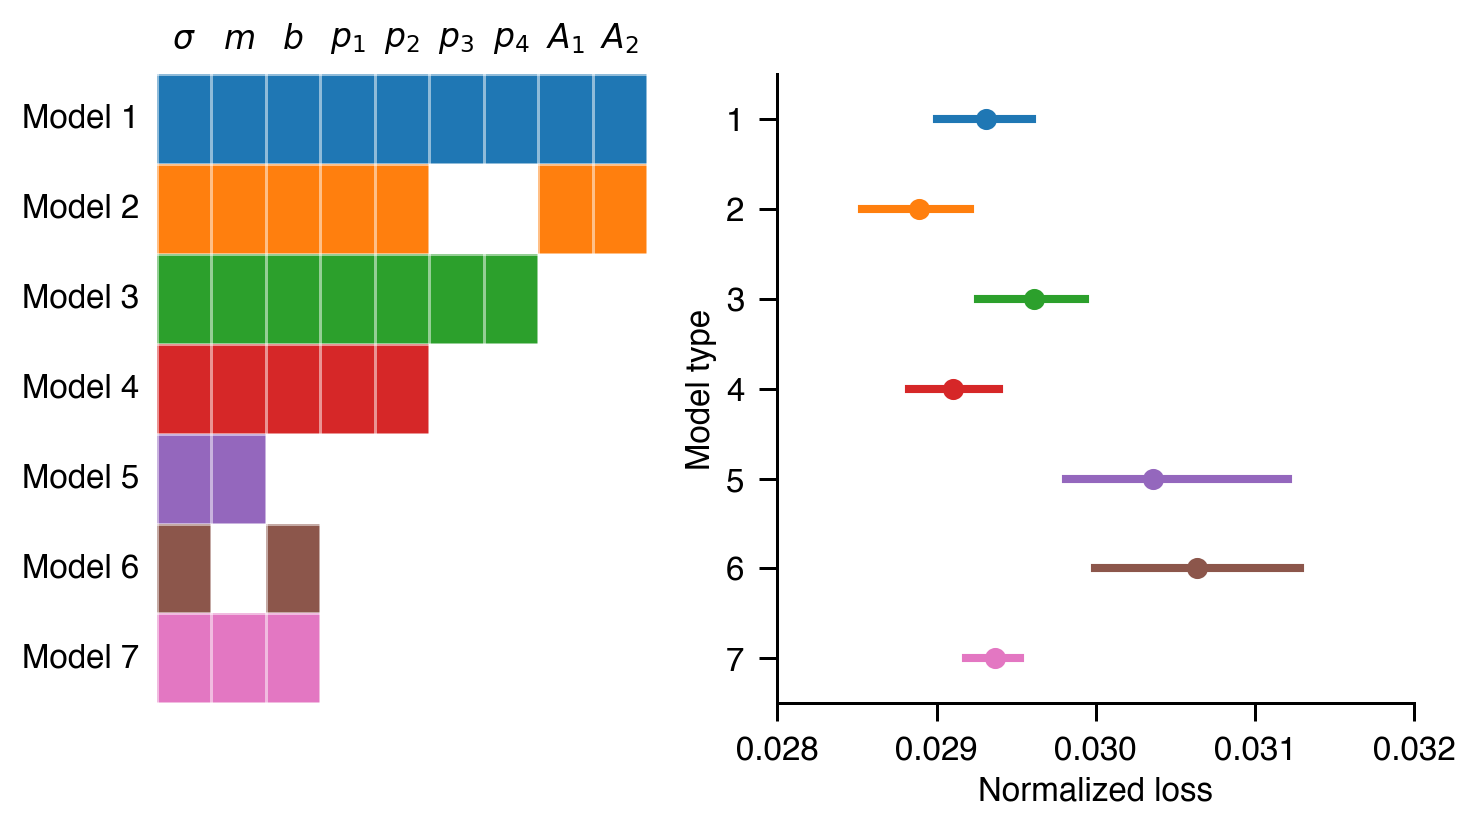

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [1, 1.3]})
cv2d.show_model_type(data=None, ax=axes[0])

normalized_df = cv2d.normalize_loss_across_model(loss_df, add_mean=True, match_broderick=True)
cv2d.plot_model_comparison(normalized_df.query('model_type != "train"'),
                           ax=axes[1], 
                           y='model_type', 
                           x='normalized_loss', 
                           hue='model_type',
                           palette=tab10_palette_7,
                           xlim=(0.028, 0.032),
                           save_path=None, **{'scale': 0.8})

fig.tight_layout()



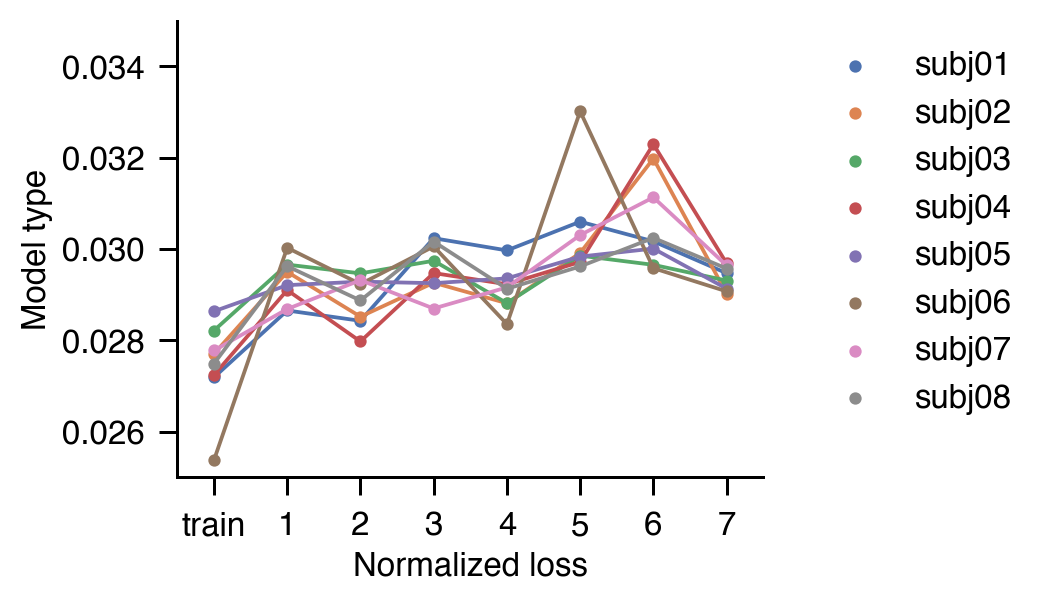

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.8))
cv2d.plot_model_comparison(normalized_df,
                           ax=ax, 
                           x='model_type', 
                           y='normalized_loss', 
                           orient='v',
                           palette='deep',
                           hue='subj',
                           ylim=[0.025, 0.035],
                           save_path=None, **{'scale': 0.7, 'dodge': False})


In [45]:
model_df = pd.DataFrame({})
for subj, model_type in product(subj_list, model_type_list):
    tmp = pd.read_csv(os.path.join(config['OUTPUT_DIR'],'sfp_model',
                                   'cross_validation',
                                   f'{dset}',
                                   f'model-{model_type}',
                                   f'cvresults_bts-False_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-{roi}_vs-{vs}.csv'))
    tmp['sub'] = subj
    tmp['model_type'] = model_type
    model_df = pd.concat([model_df, tmp], axis=0)
model_df

,fold,test_classes,sigma,slope,intercept,p_1,p_2,p_3,p_4,A_1,A_2,sub,model_type
0,0,[18 16 3 21],2.528584,0.135677,0.273609,-0.094468,0.024804,-0.192949,-0.007711,0.085125,-0.020095,subj01,1
1,1,[ 5 6 2 27],2.381408,0.172235,0.217421,-0.051729,0.016940,-0.289116,0.044692,0.077384,-0.011702,subj01,1
2,2,[12 7 10 17],2.653118,0.125977,0.341817,-0.100426,-0.010608,-0.184935,0.045035,0.087633,-0.013171,subj01,1
3,3,[ 0 26 25 14],2.450733,0.154401,0.244995,-0.067695,0.012135,-0.305609,0.035673,0.072337,-0.013143,subj01,1
4,4,[23 24 19 8],2.558670,0.140593,0.284998,-0.055584,-0.020705,-0.315272,0.039840,0.085760,-0.013825,subj01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2,[ 1 17 16 9],2.213323,0.230412,0.103602,NaN,NaN,NaN,NaN,NaN,NaN,subj08,7
3,3,[22 21 18 3],2.571122,0.223512,0.082026,NaN,NaN,NaN,NaN,NaN,NaN,subj08,7
4,4,[ 5 15 13 19],2.324945,0.212169,0.098469,NaN,NaN,NaN,NaN,NaN,NaN,subj08,7
5,5,[ 6 8 20 14],2.362155,0.204183,0.066748,NaN,NaN,NaN,NaN,NaN,NaN,subj08,7


In [46]:
pt_file_list = []
for subj in subj_list:
    file_name = f'model-params_lr-{lr}_eph-{max_epoch}_sub-{subj}_roi-V1_vs-pRFsize.pt'
    pt_file_list.append(f'/Volumes/server/Projects/sfp_nsd/derivatives/sfp_model/results_2D/nsdsyn/corrected/' + file_name)
train_df = two_d.load_all_models(pt_file_list, *['sub'])
train_df['model_type'] = 'train'

model_df = pd.concat([model_df, train_df], axis=0)

In [47]:
nsd_precision_s =  pd.read_csv(f'/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision/precision-s_dset-nsdsyn_vs-pRFsize.csv')
nsd_precision_s = nsd_precision_s.query('vroinames == "V1"')
model_df = pd.merge(model_df, nsd_precision_s[['sub','precision']], on=['sub'])

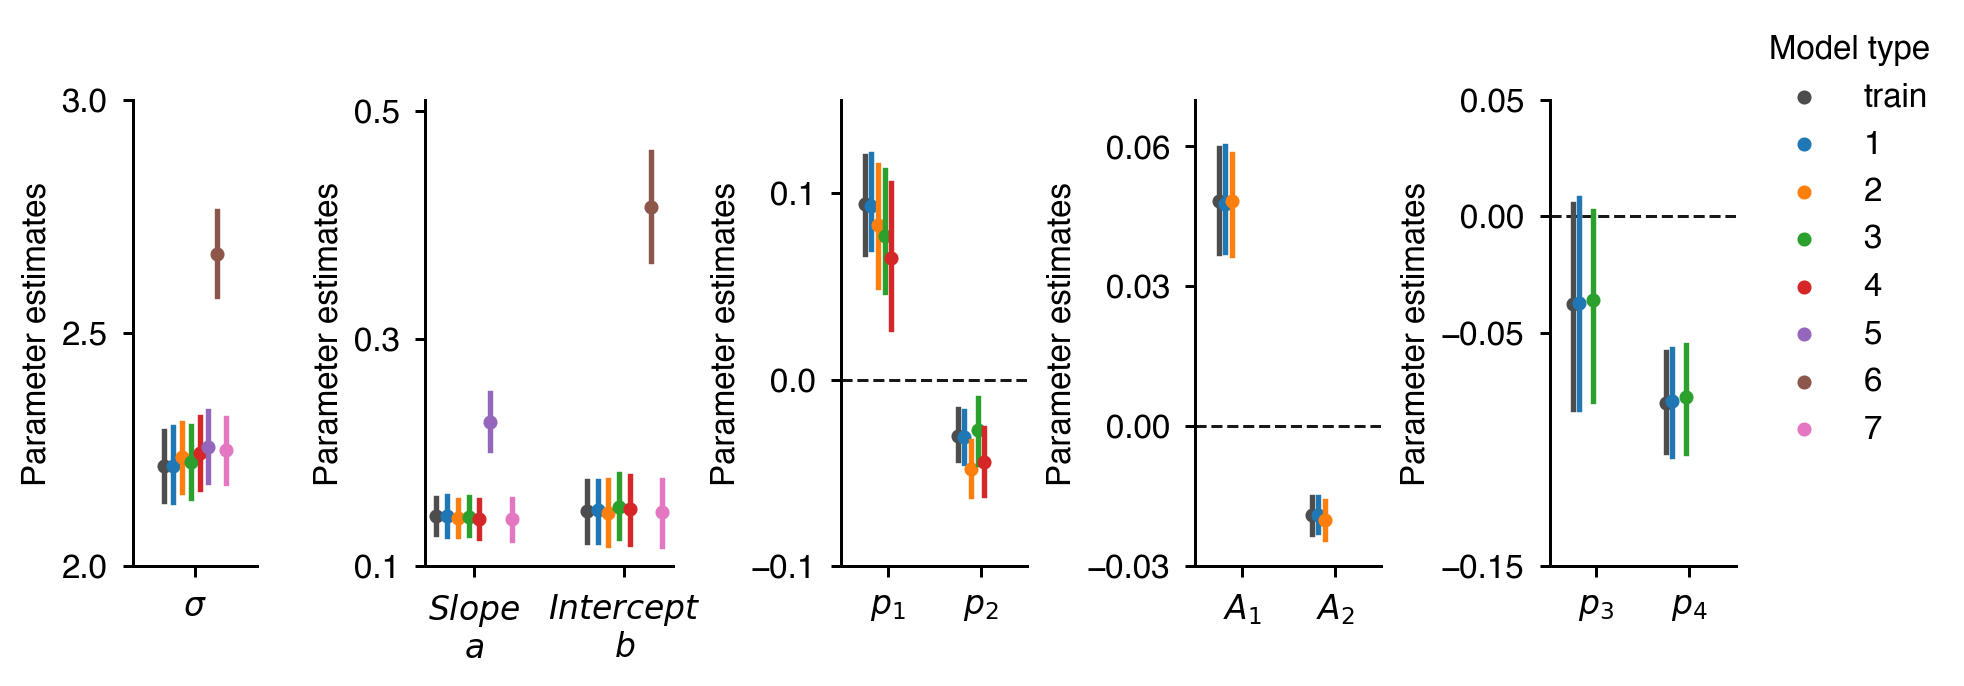

In [ ]:
ylim_list = [(2, 3), (0.1, 0.51), (-0.1, 0.15),(-0.03,0.07), (-0.15, 0.05)]
yticks_list=  [[2,2.5,3], [0.1, 0.3, 0.5], [-0.1,0,0.1], [-0.03,0,0.03, 0.06], [-0.15,-0.1,-0.05,0]]
model_avg_df = model_df.groupby(['sub', 'model_type']).mean().reset_index()
tab10_palette_7 = sns.color_palette("tab10", 7)
tab10_palette_7_with_black = [(0.3, 0.3, 0.3)] + list(tab10_palette_7)
params_list = [['sigma'], ['slope', 'intercept'], ['p_1', 'p_2'], ['A_1', 'A_2'], ['p_3', 'p_4']]
cv2d.plot_model_params(model_avg_df, 
                       params_list, 
                       hue='model_type', 
                       hue_order=['train'] + model_type_list,
                       ylim=ylim_list, 
                       yticks=yticks_list,
                       weighted_average=False,
                       save_path=None, **{'palette': tab10_palette_7_with_black})

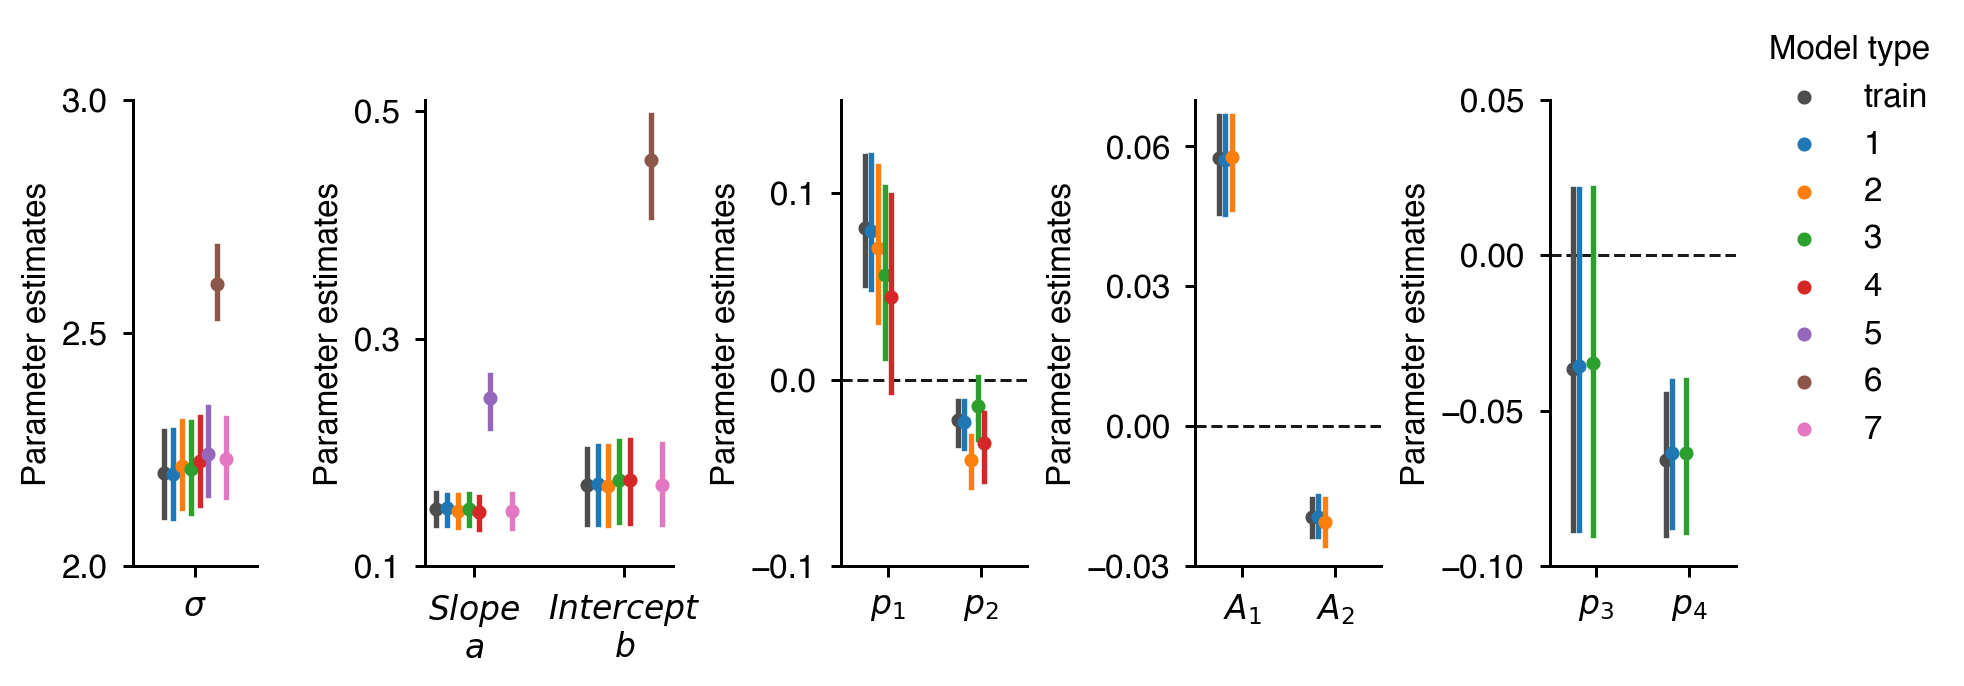

In [ ]:
ylim_list = [(2, 3), (0.1, 0.51), (-0.1, 0.15),(-0.03,0.07), (-0.15, 0.05)]
yticks_list=  [[2,2.5,3], [0.1, 0.3, 0.5], [-0.1,0,0.1], [-0.03,0,0.03, 0.06], [-0.15,-0.05,0,0.05]]
cv2d.plot_model_params(model_avg_df, params_list, 
                       hue='model_type', ylim=ylim_list, yticks=yticks_list,
                       hue_order=['train'] + model_type_list,
                       weighted_average=True,
                       save_path=None, **{'palette': tab10_palette_7_with_black})


In [47]:
import sfp_nsdsyn.two_dimensional_model as model
model.SpatialFrequencyModel(model=2)

TypeError: cannot assign 'int' as parameter 'p_3' (torch.nn.Parameter or None expected)

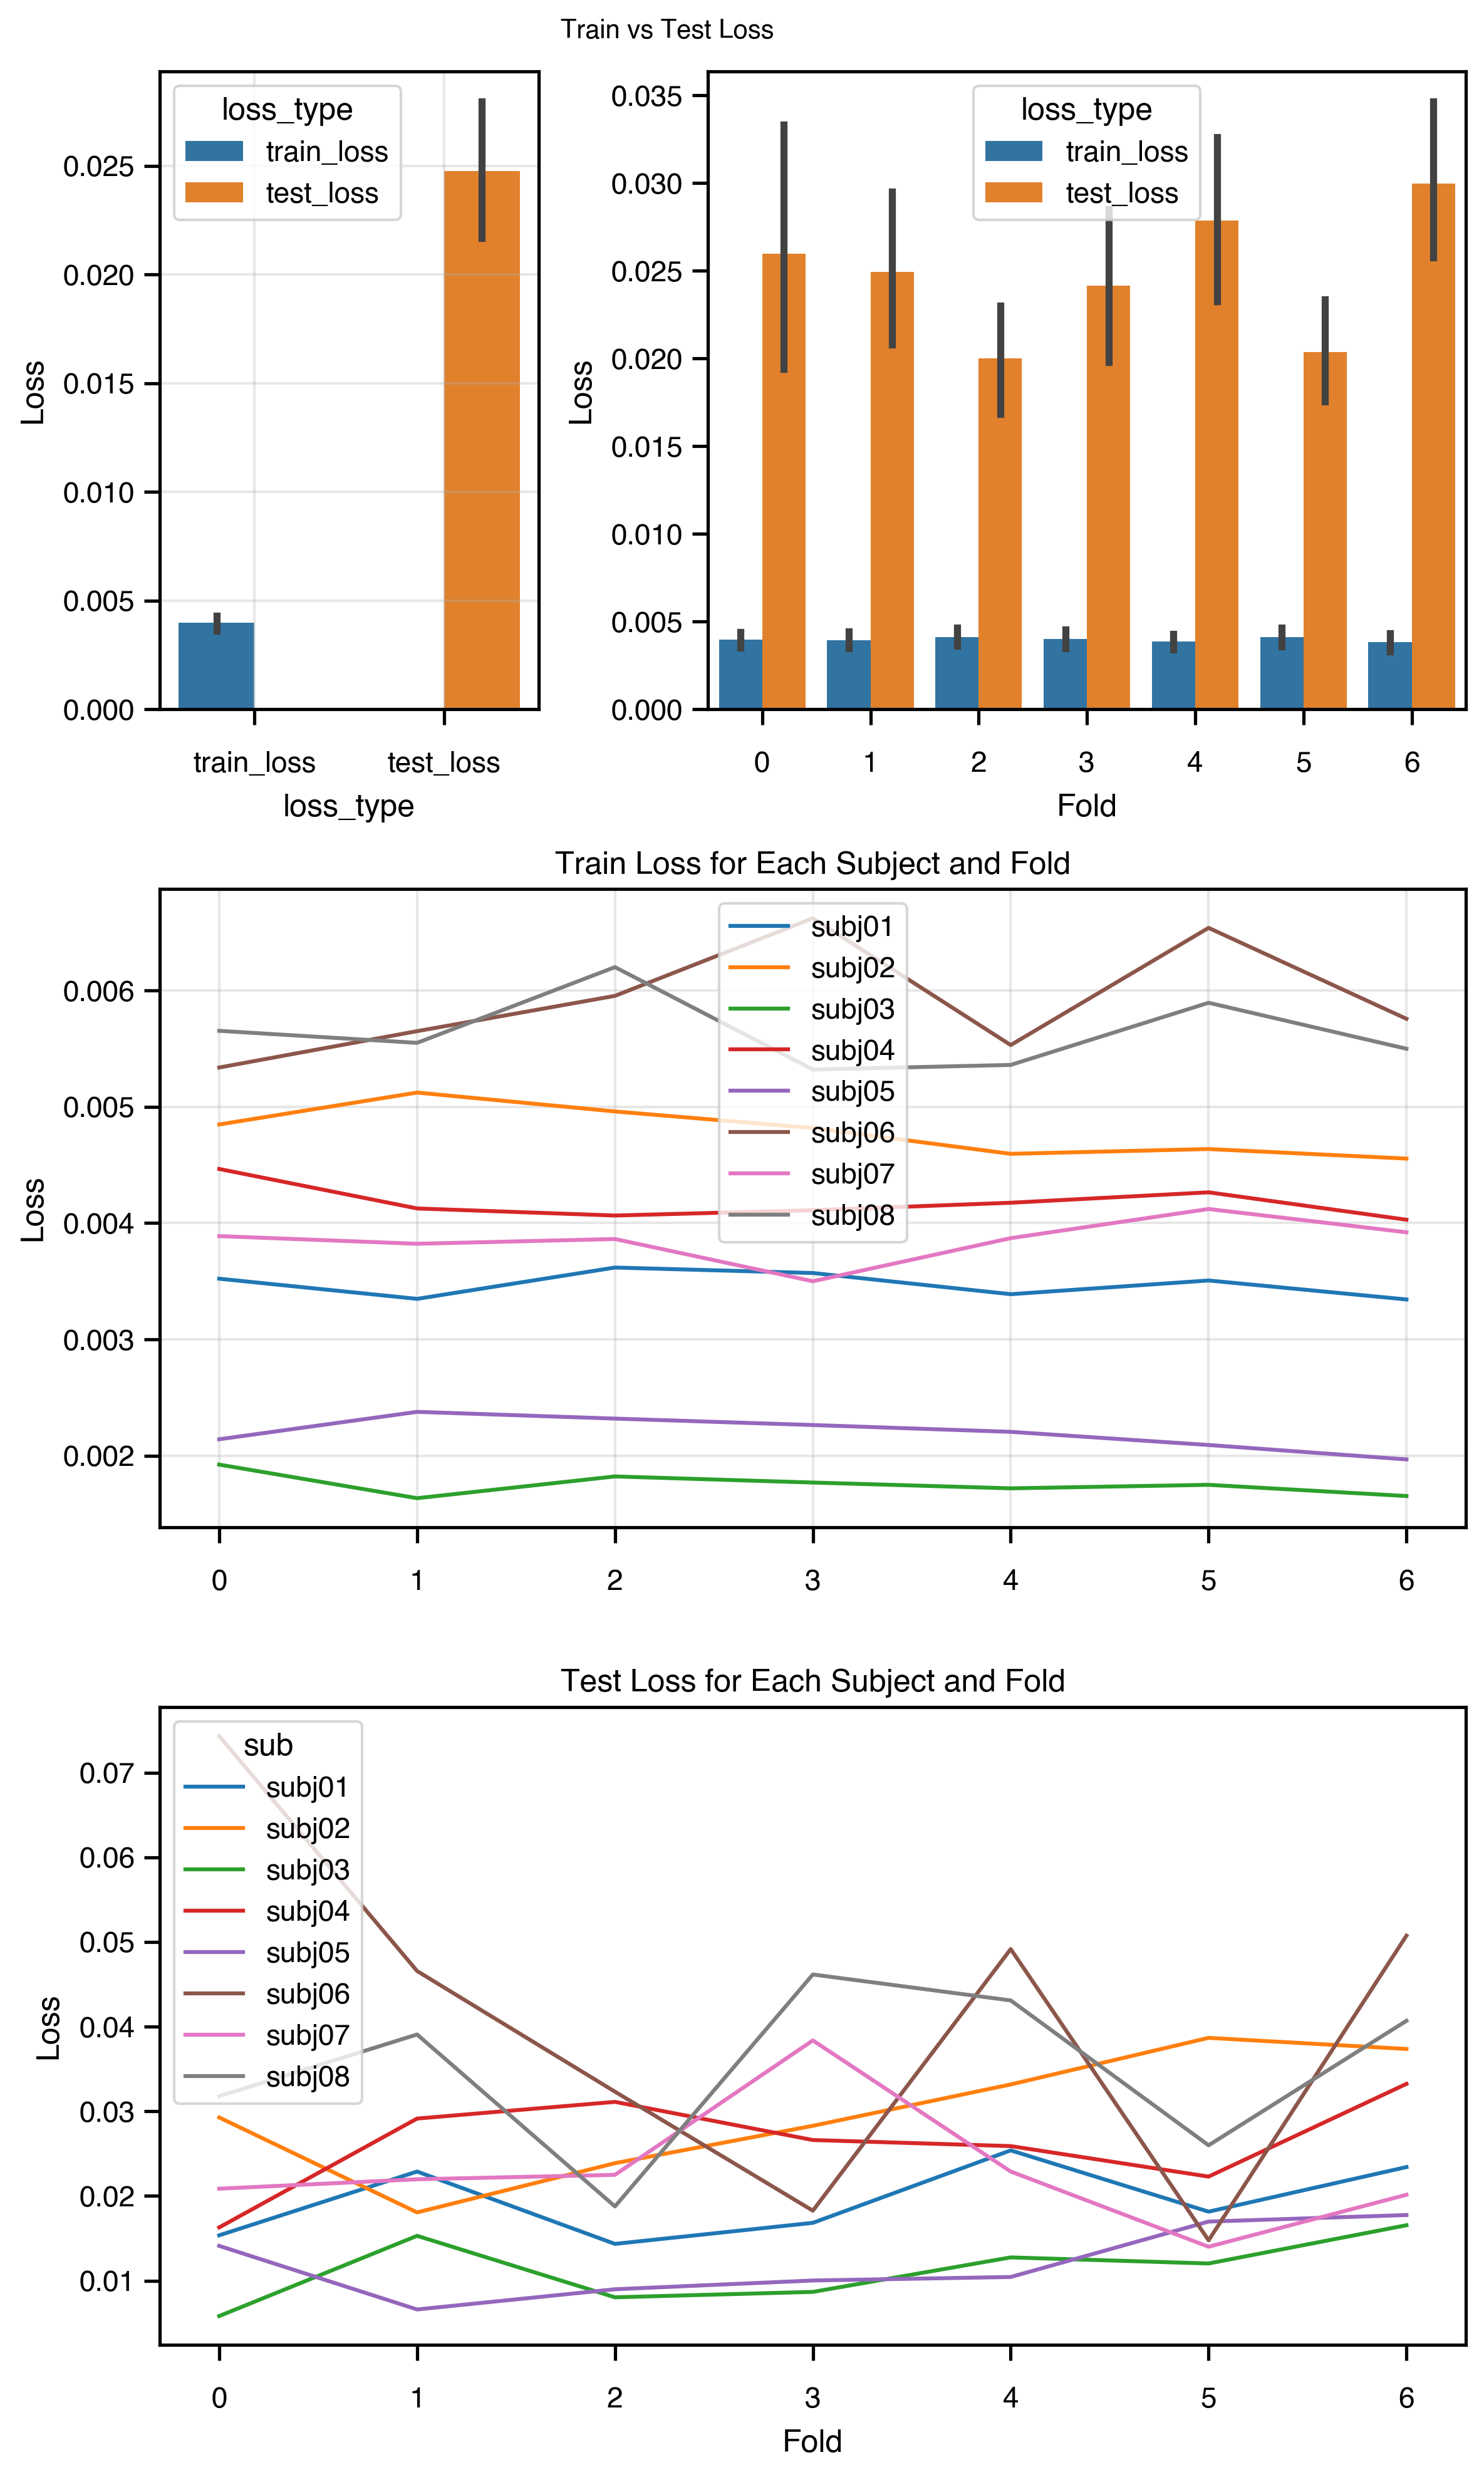

In [3]:
sample_df = all_df[['sub','fold','train_loss','test_loss','model_params']]
cv2d.plot_cv_results_group(sample_df, save_path='/Volumes/server/Projects/sfp_nsd/derivatives/figures/cross_validation/cv_results_group.png')